In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import xlsxwriter
from PIL import Image
import os
from PIL.ExifTags import TAGS
import piexif
import random
from os import listdir
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
#read in excel files
xls18 = pd.ExcelFile('NHL 2017-18.xls')
season18 = pd.read_excel(xls18, 'TOT',header=2)
#xls17 = pd.ExcelFile('NHL 2016-17.xls')
#season17 = pd.read_excel(xls17, 'All Sits',header=2)
#shots=pd.read_csv("shots_2017.csv")

In [3]:
season18=season18[season18.columns[~season18.columns.isin(["TOI.1","TOI.2","TOI.3","iCF.1","iCF.2","iFF.1","iHF.1","iPENT2",
                                                  "iPENT5","iPEND2","iPEND5",'CF.1','CA.1','FF.1','FA.1','SF.1','SA.1'
                                                  ,'GF.1','GA.1','GP.1', 'G.1', 'A.1', 'PTS.1', '+/-.1','PIM.1',
                                                  'TOI.4', 'OPS.1', 'DPS.1', 'PS.1','A1'])]]

In [4]:
season18=season18[season18['Cap Hit']>1000000]
season18=season18.reset_index(drop=True)

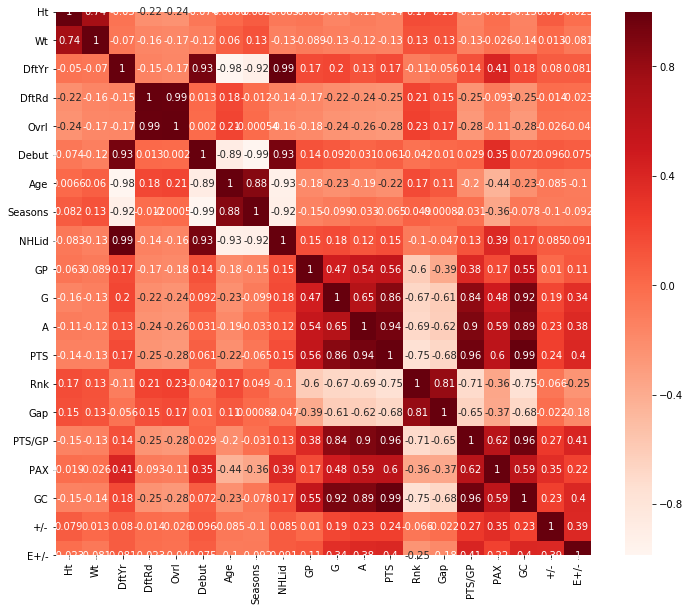

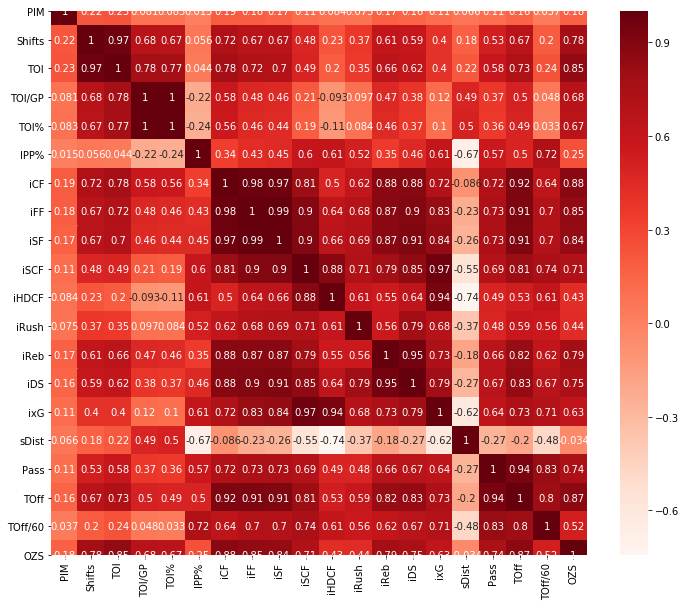

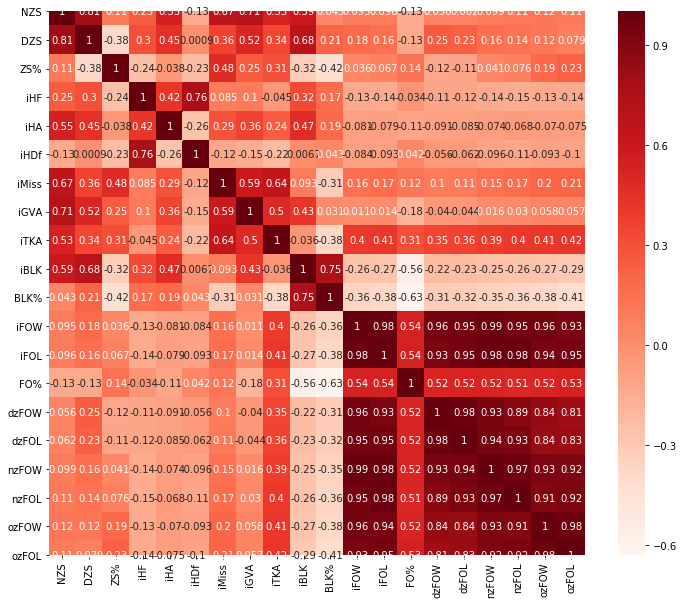

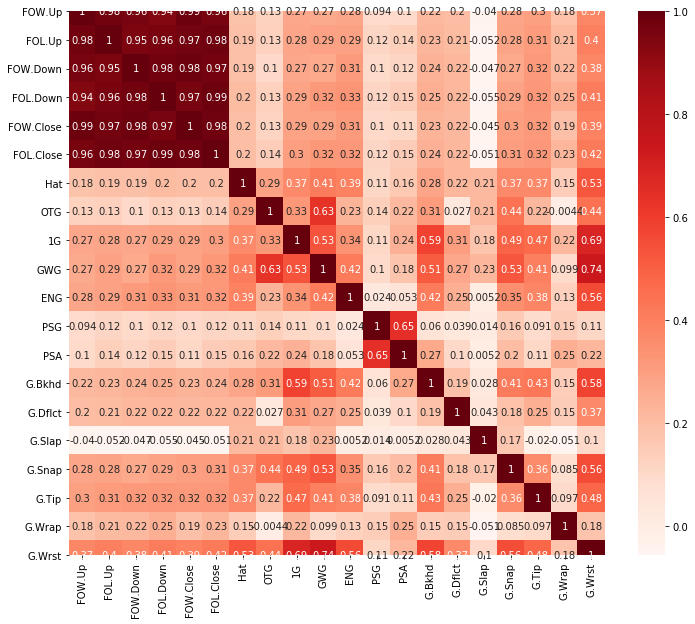

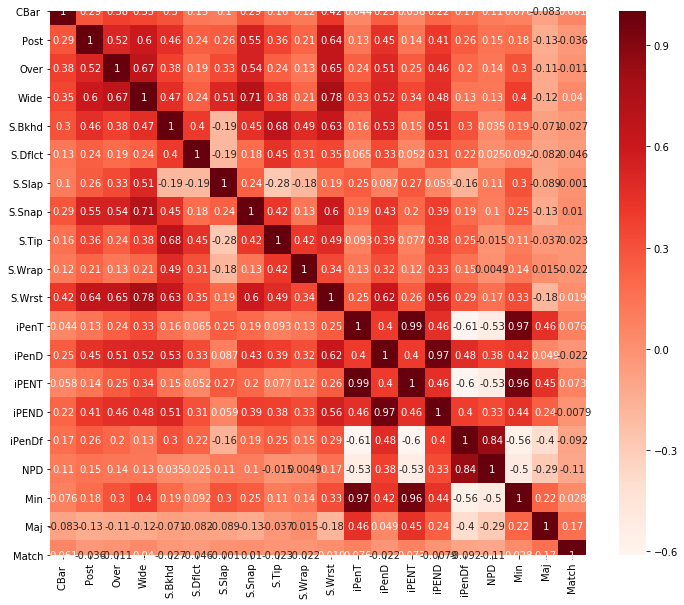

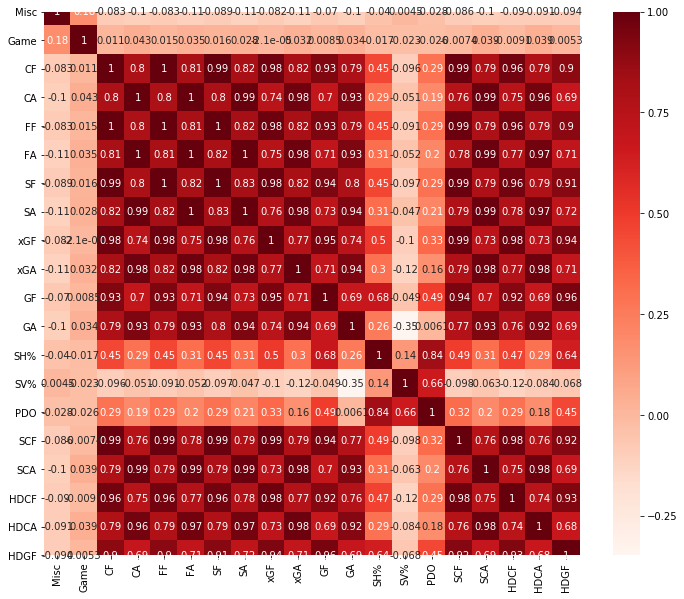

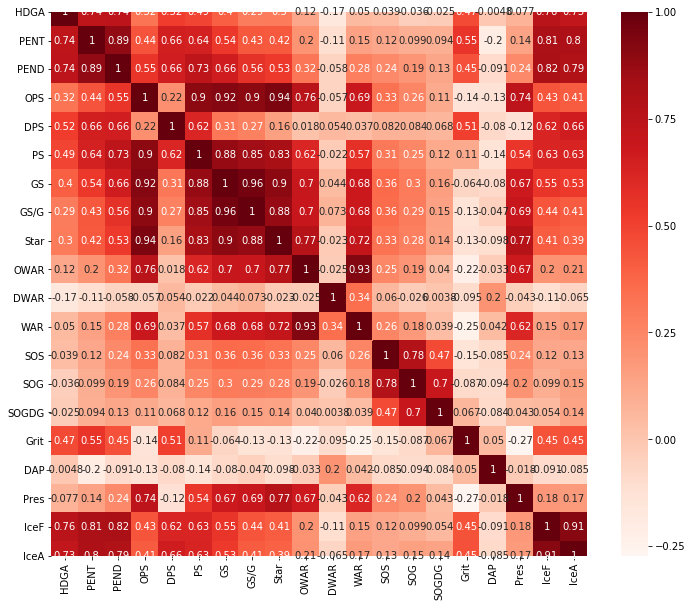

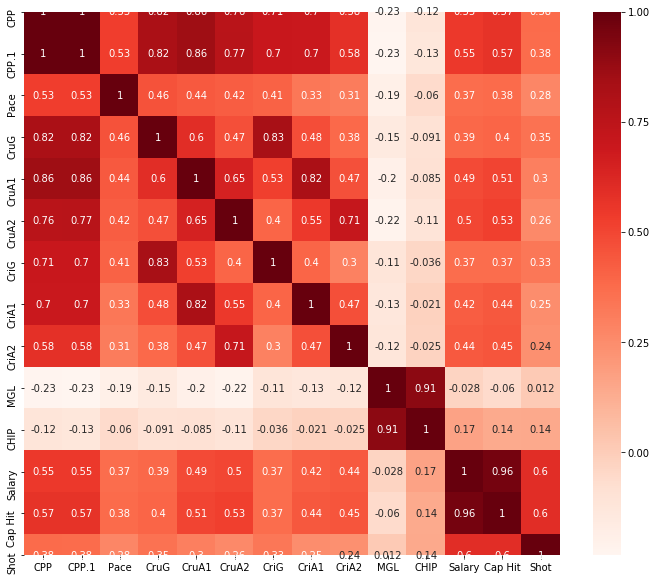

In [5]:
corr = season18.corr()
for i in range(0,int(season18.shape[1]/20)):
    plt.figure(figsize=(12,10))
    sns.heatmap(corr.loc[corr.columns[i*20:i*20+20],corr.columns[i*20:i*20+20]], annot=True, cmap=plt.cm.Reds)
    plt.show()

In [6]:
modelSeason18=season18.copy()
modelSeason18.reset_index(drop=True,inplace=True)

In [7]:
names=modelSeason18['CorsicaID']

In [8]:
modelSeason18.drop(modelSeason18.columns[modelSeason18.dtypes=='object'], axis=1, inplace=True)
modelSeason18.drop(['Born'], axis=1, inplace=True)

In [9]:
modelSeason18.shape

(395, 154)

In [10]:
modelSeason18.fillna('?',inplace=True)

In [11]:
for col in modelSeason18.columns:
    if modelSeason18[col].dtype == object:
        count = 0
        count = [count + 1 for x in modelSeason18[col] if x == '?']
        print(col + ' ' + str(sum(count)))

DftYr 36
DftRd 36
Ovrl 36
SOS 228
SOG 228
SOGDG 228
MGL 131
CHIP 131


In [12]:
modelSeason18.drop(['SOS','SOG','SOGDG','MGL','CHIP','Salary'], axis=1, inplace=True)

In [13]:
for column in modelSeason18.columns:
    modelSeason18.loc[modelSeason18[column] == '?', column] = np.nan
modelSeason18.dropna(axis = 0, inplace = True)
modelSeason18X=modelSeason18.drop(['Cap Hit','NHLid'], axis=1)
modelSeason18Y=modelSeason18[['Cap Hit']]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


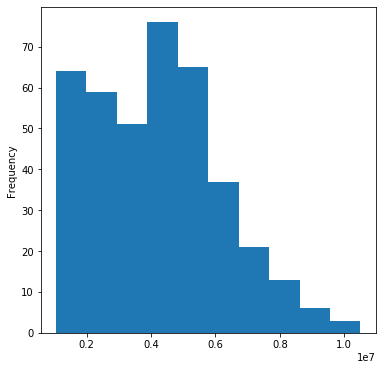

In [14]:
fig = plt.figure(figsize=(6,6)) # define plot area
ax = fig.gca()
season18['Cap Hit'].plot.hist(ax = ax, bins = 10)

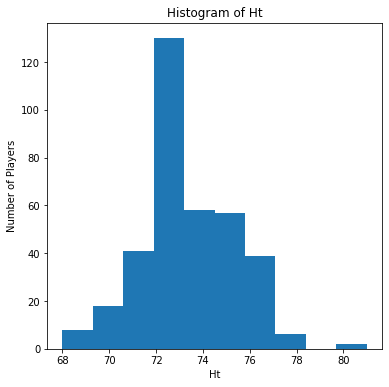

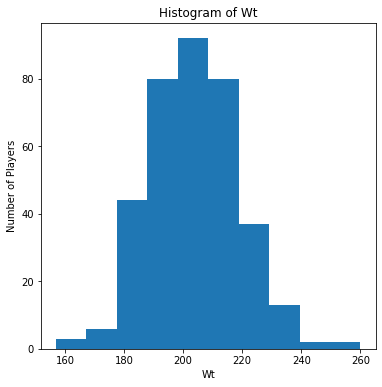

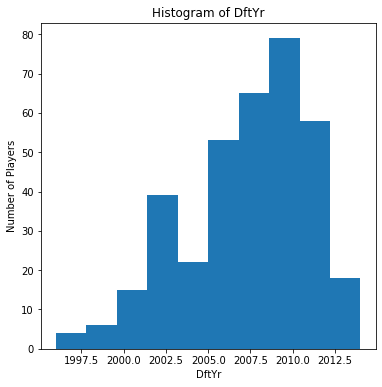

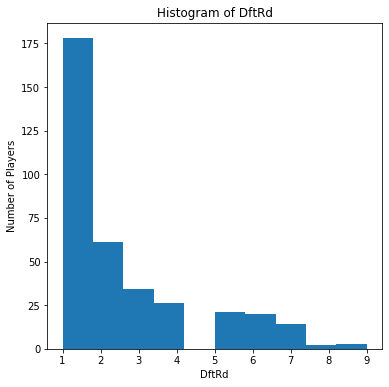

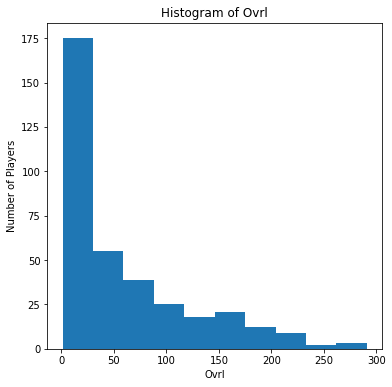

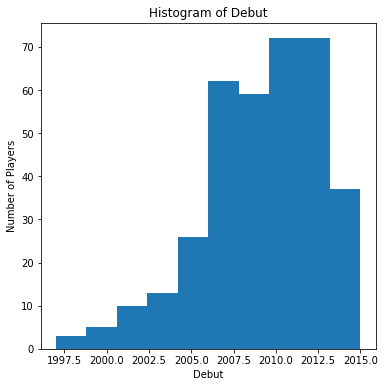

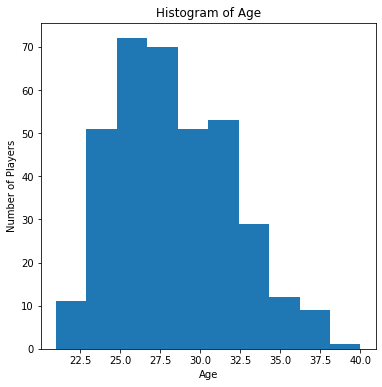

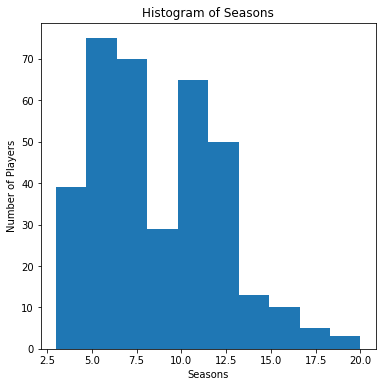

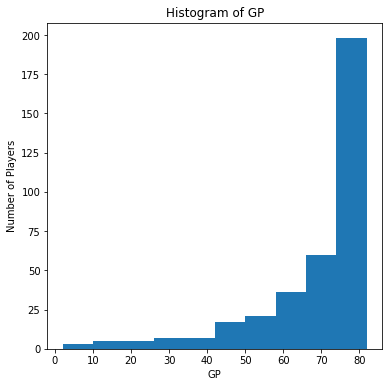

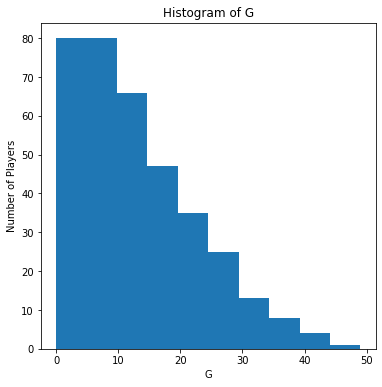

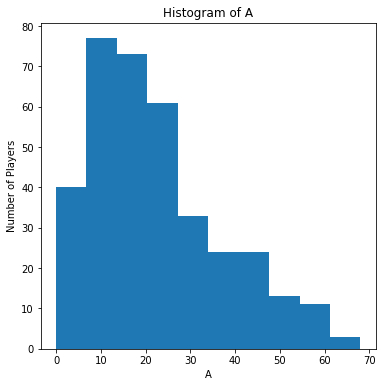

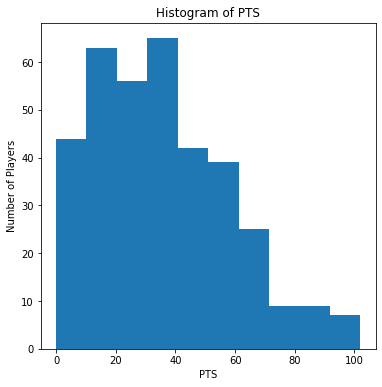

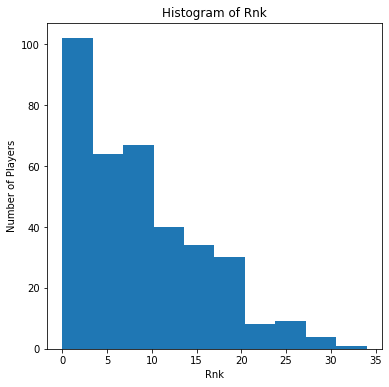

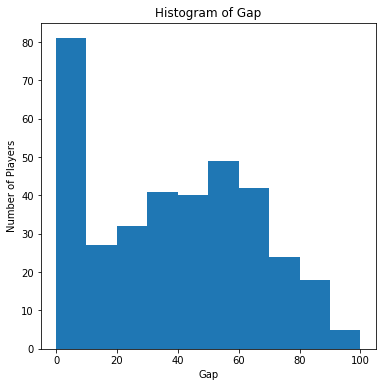

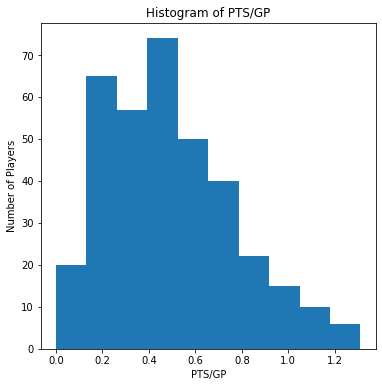

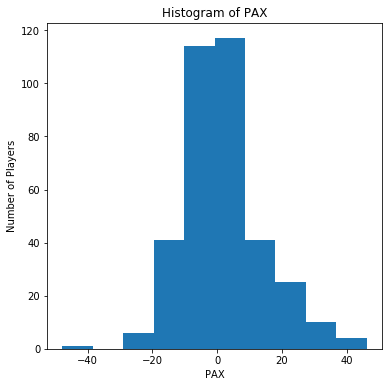

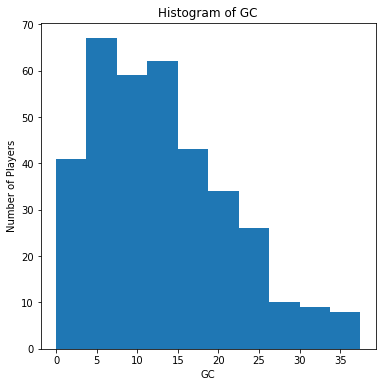

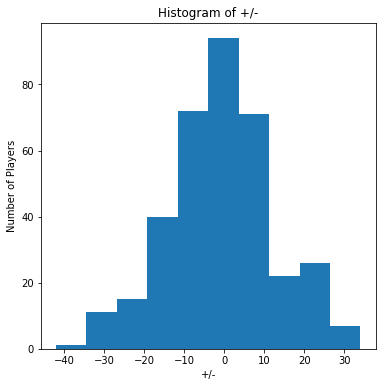

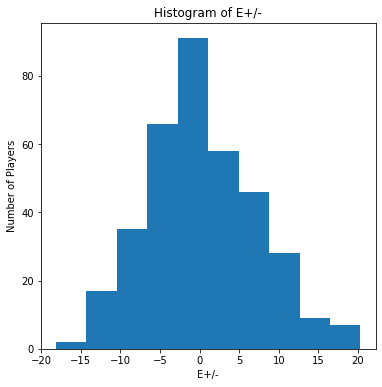

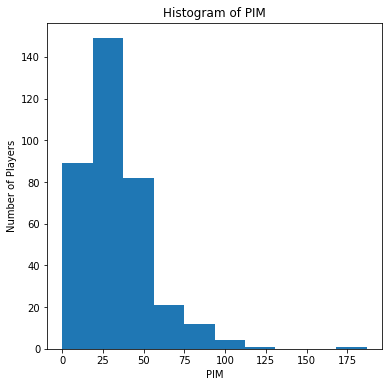

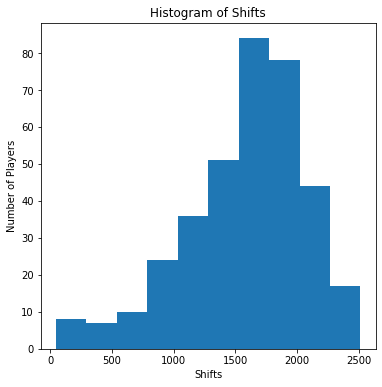

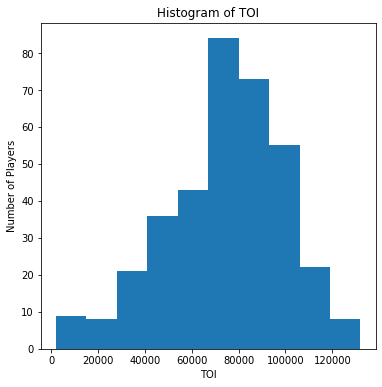

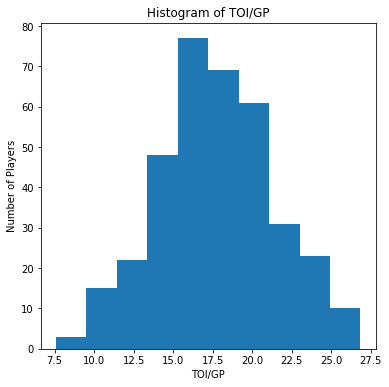

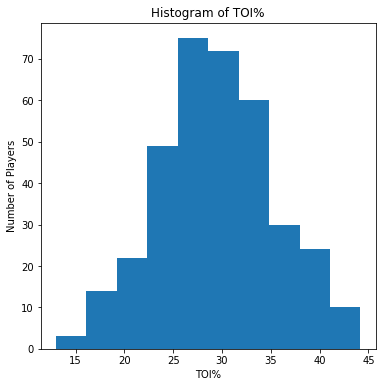

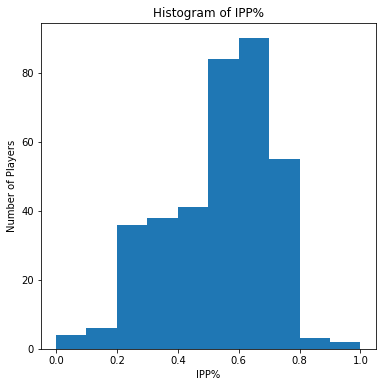

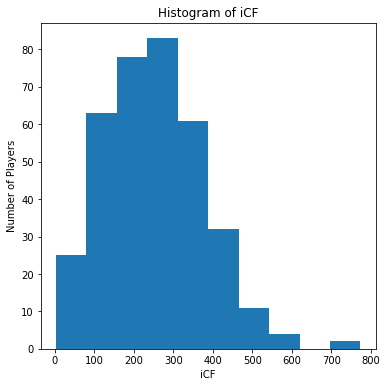

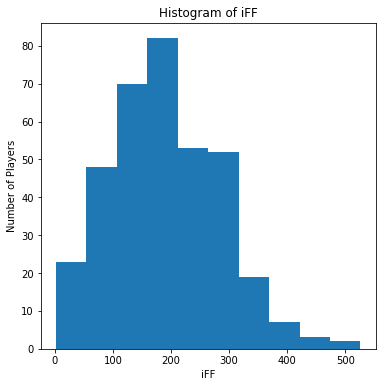

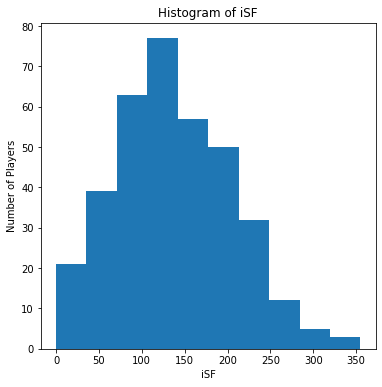

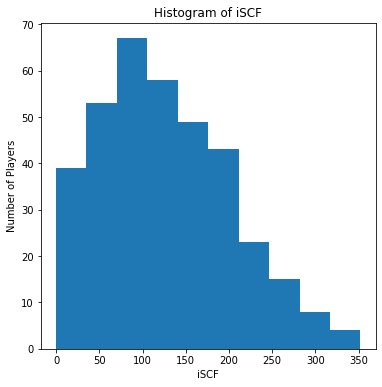

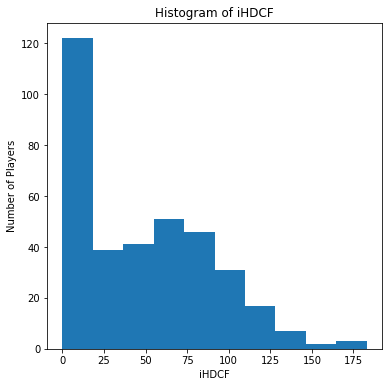

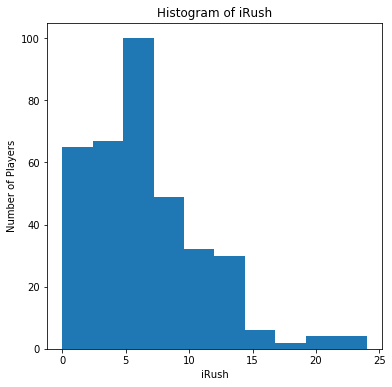

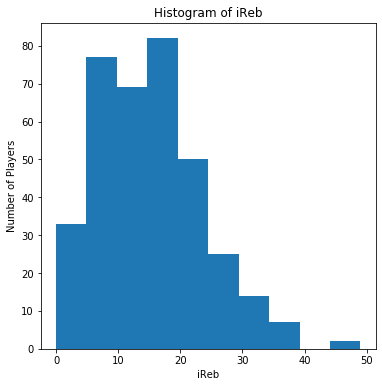

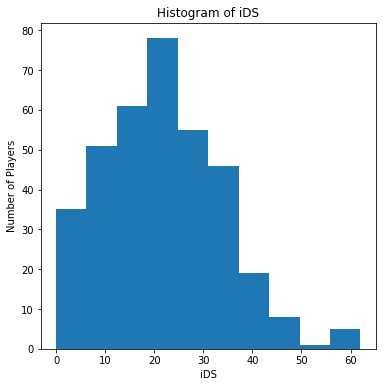

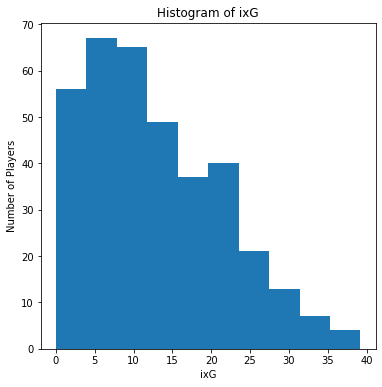

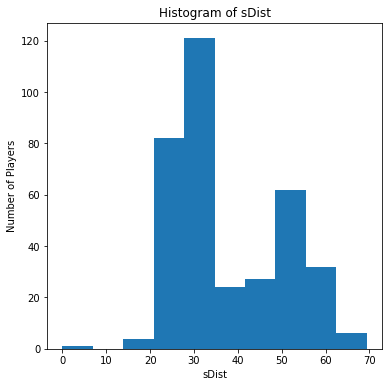

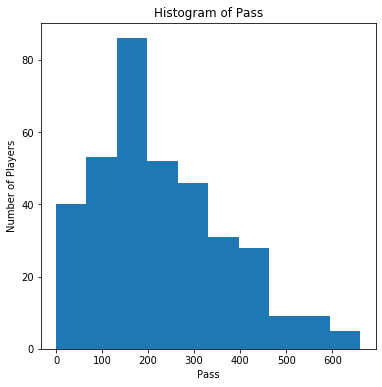

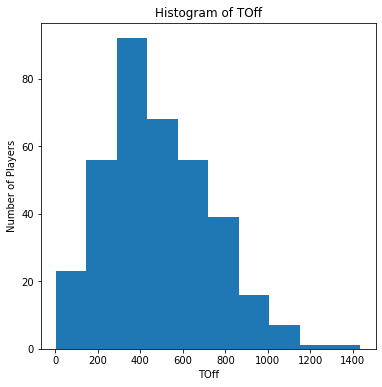

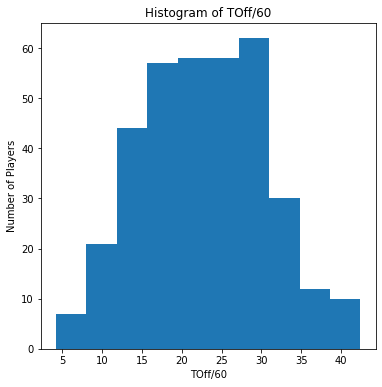

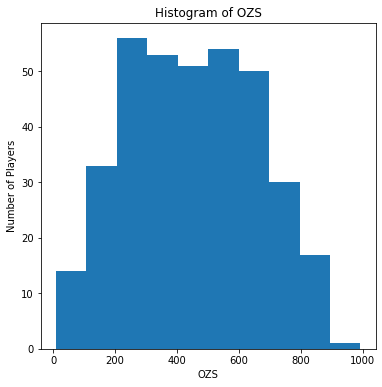

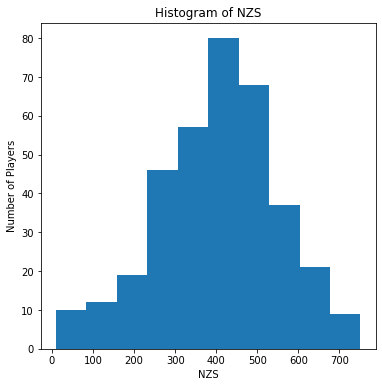

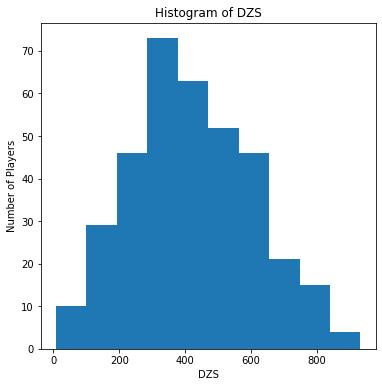

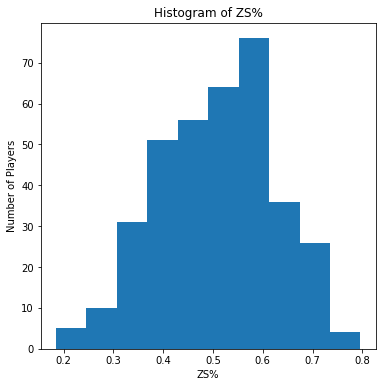

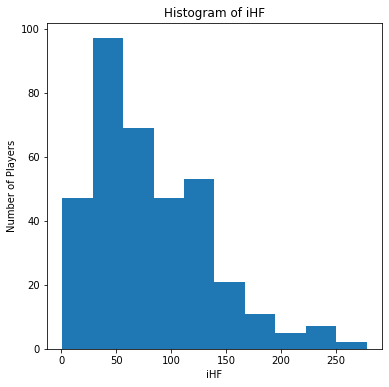

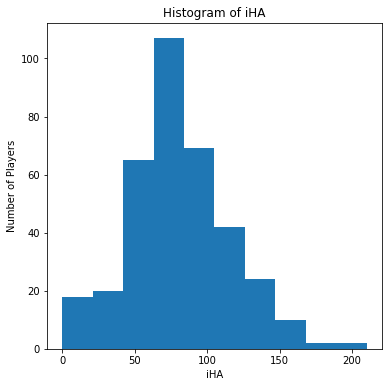

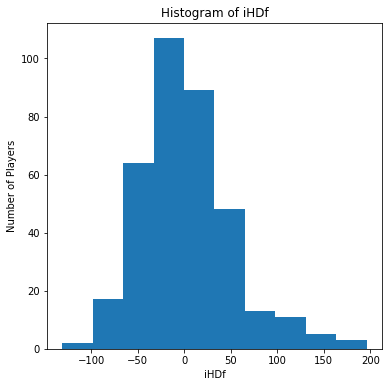

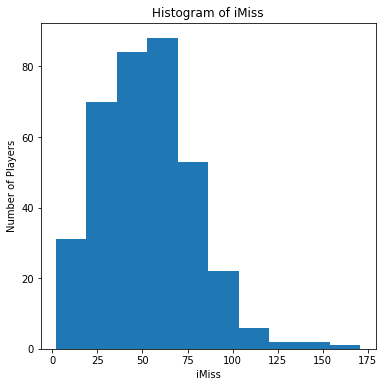

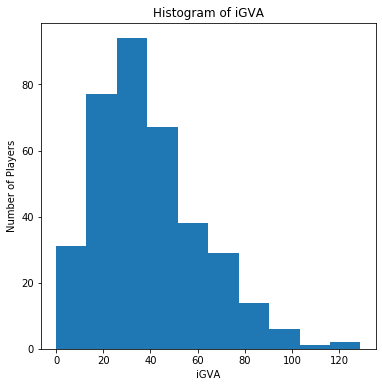

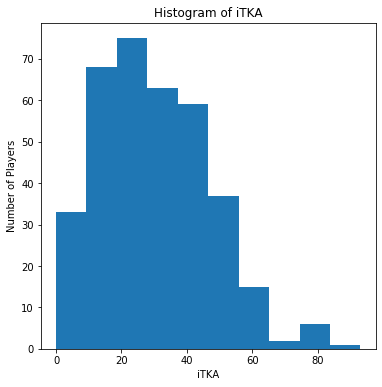

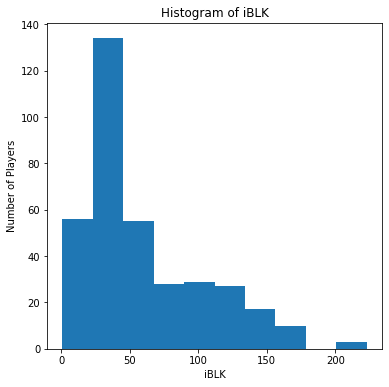

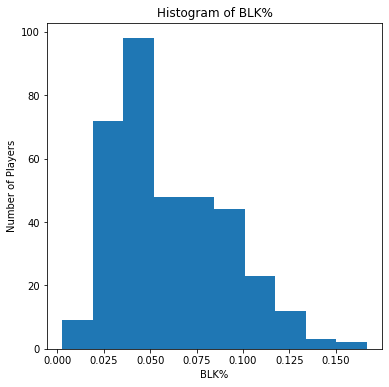

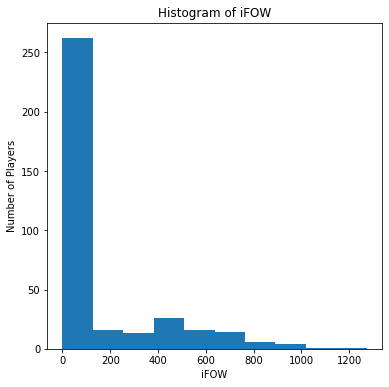

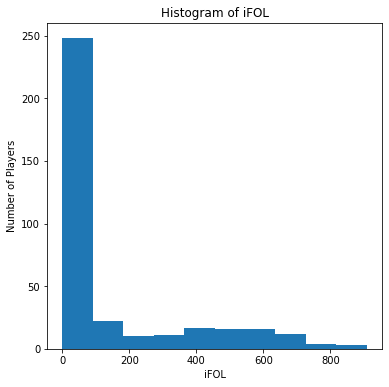

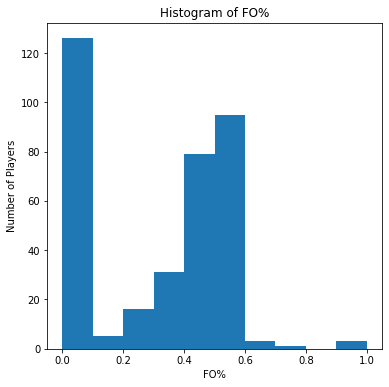

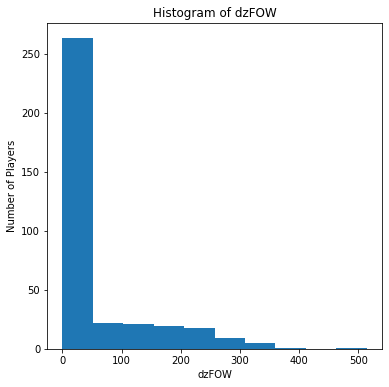

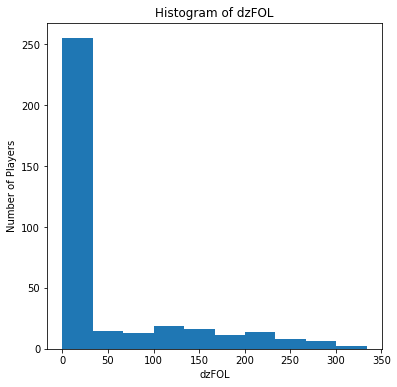

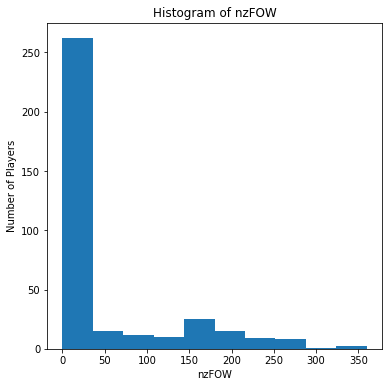

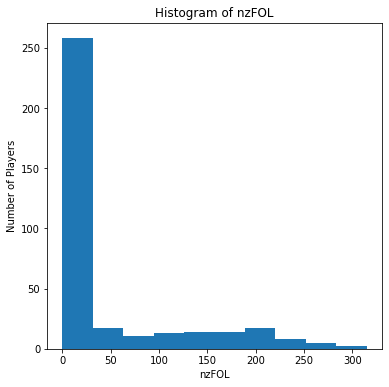

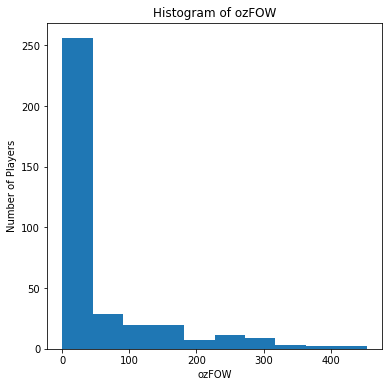

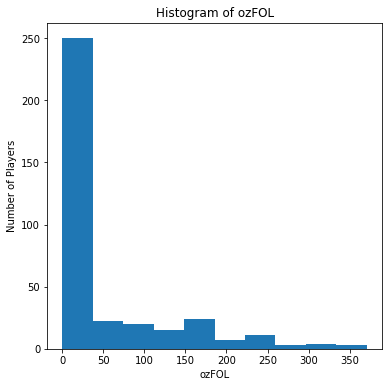

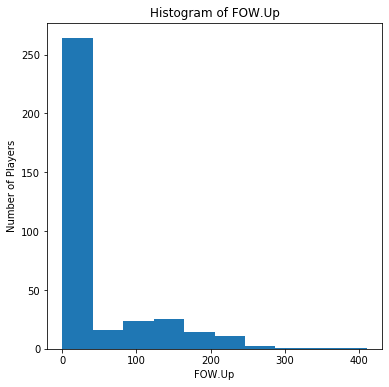

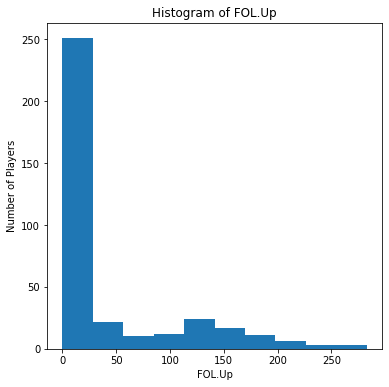

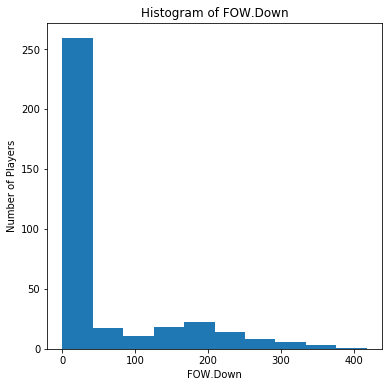

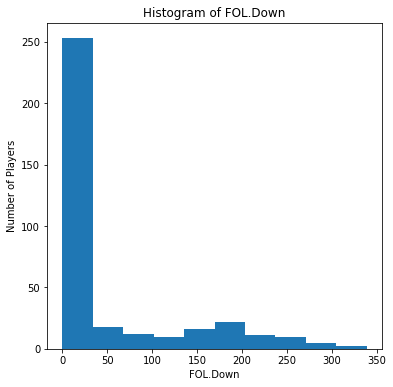

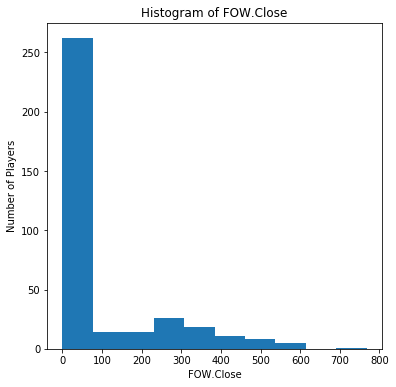

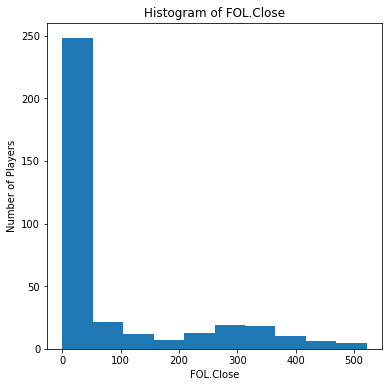

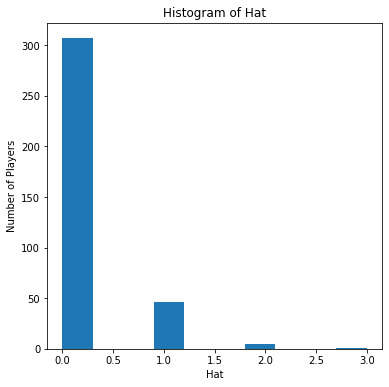

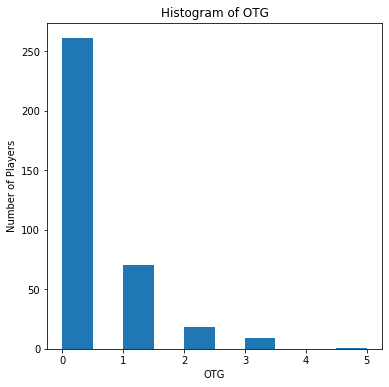

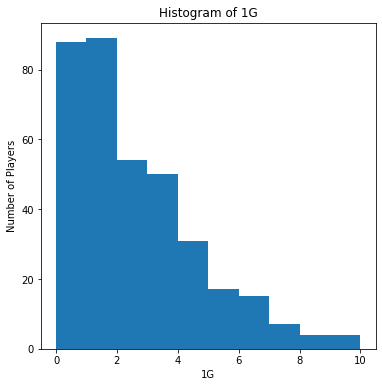

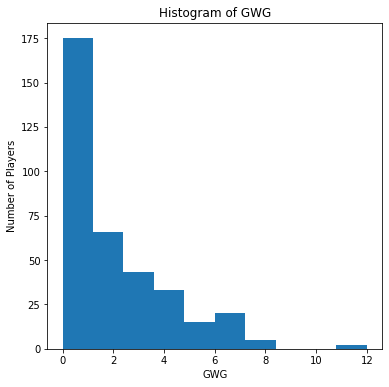

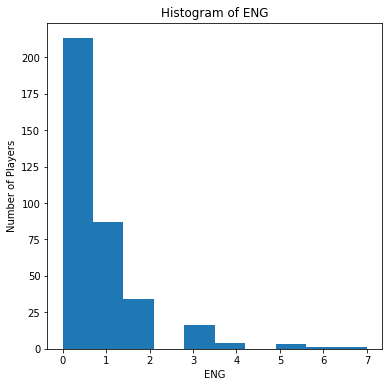

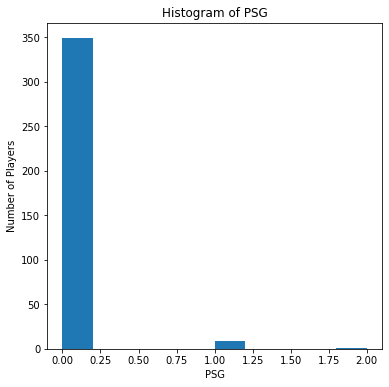

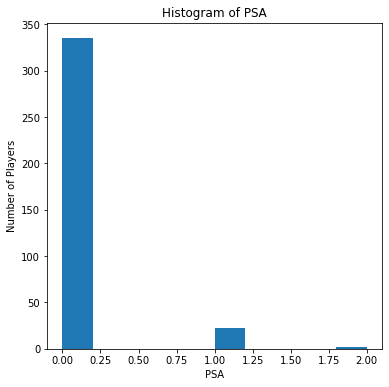

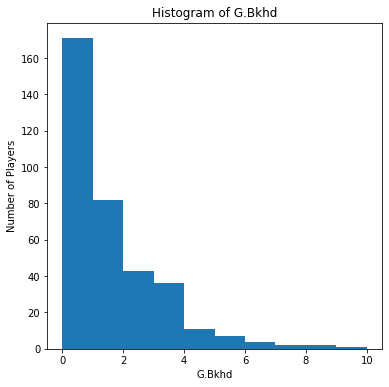

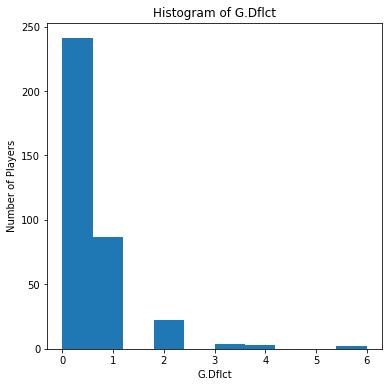

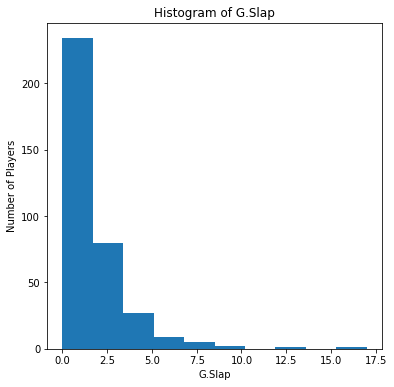

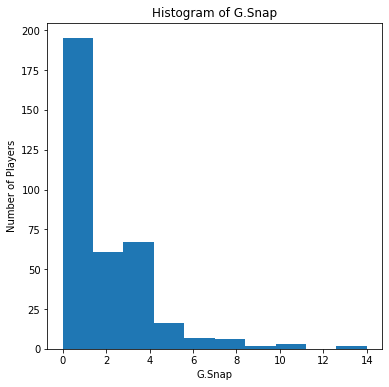

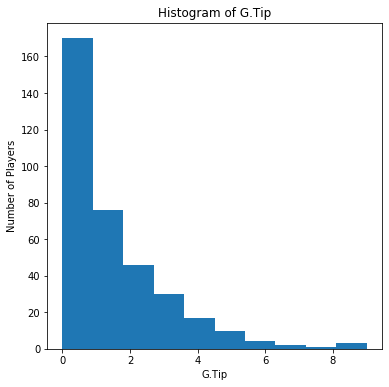

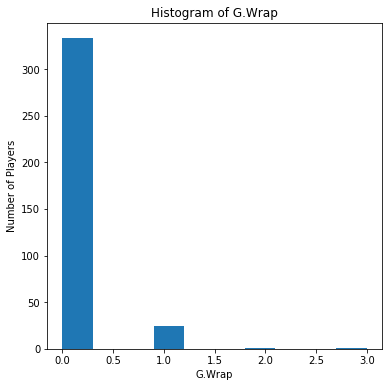

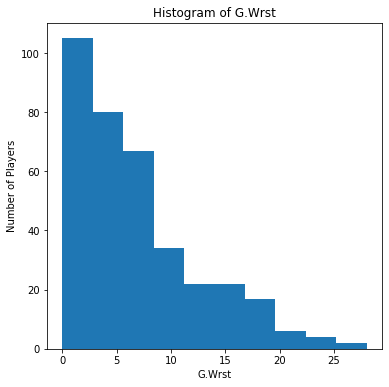

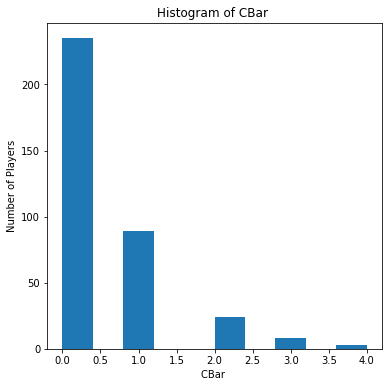

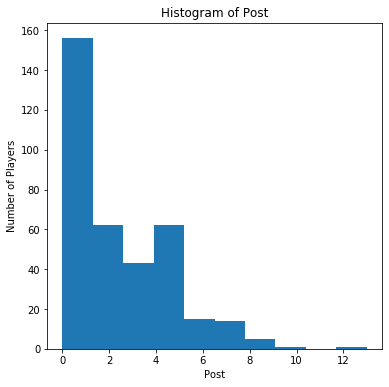

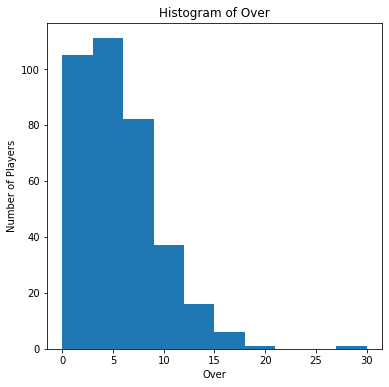

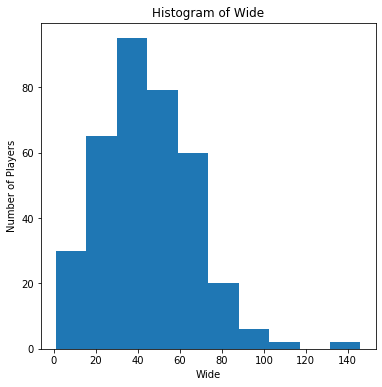

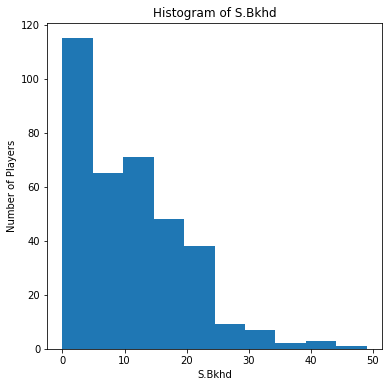

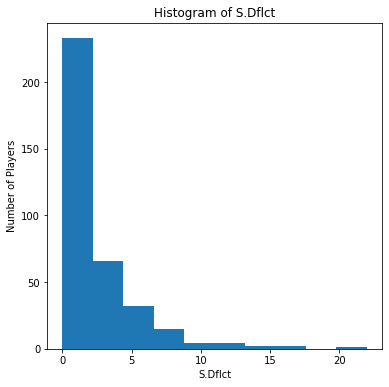

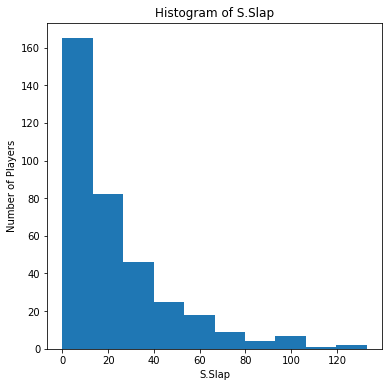

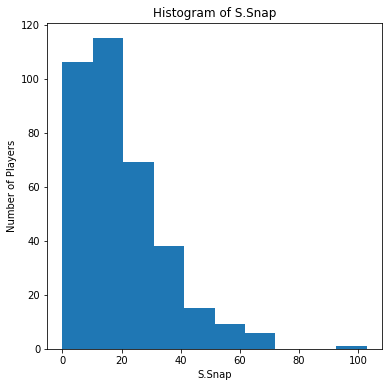

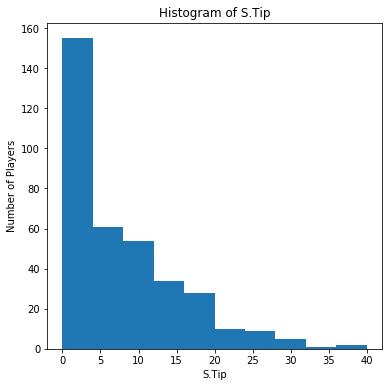

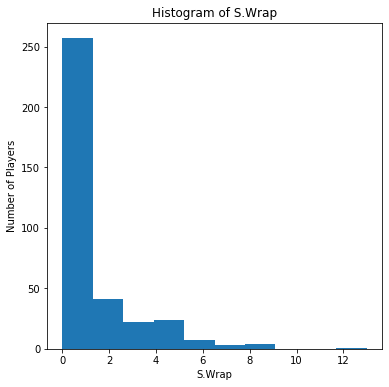

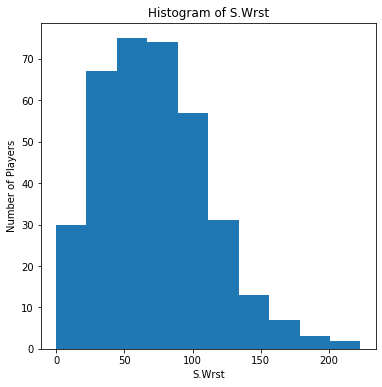

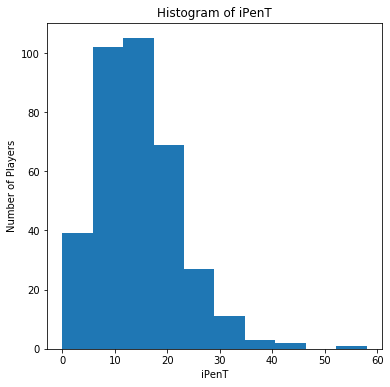

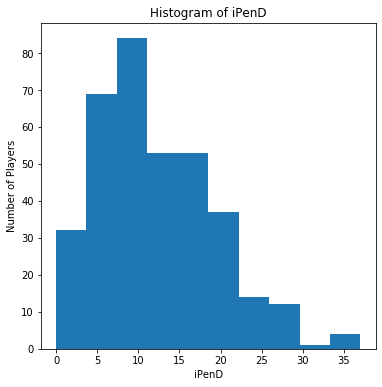

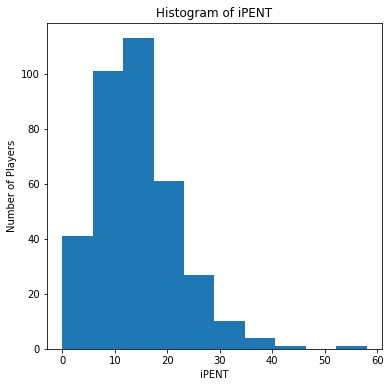

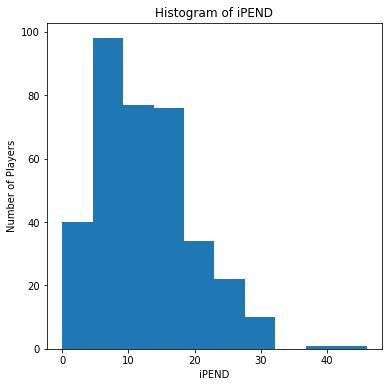

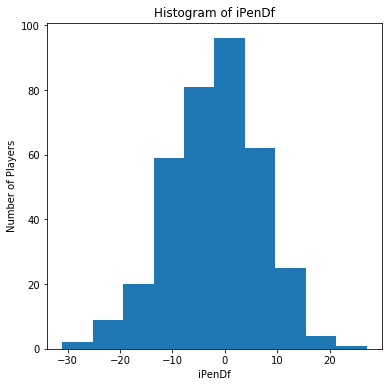

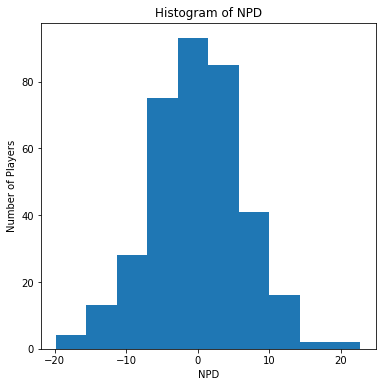

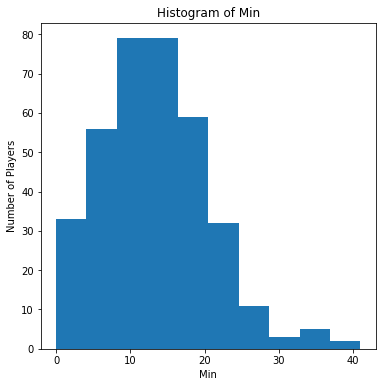

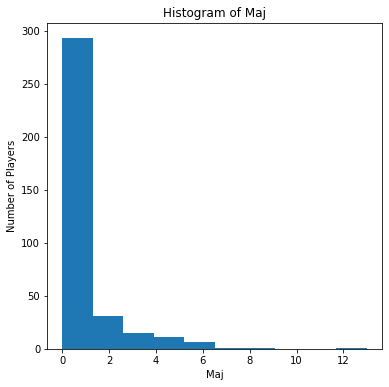

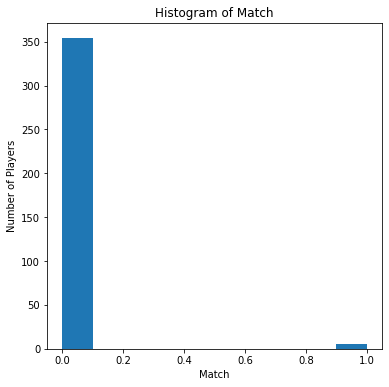

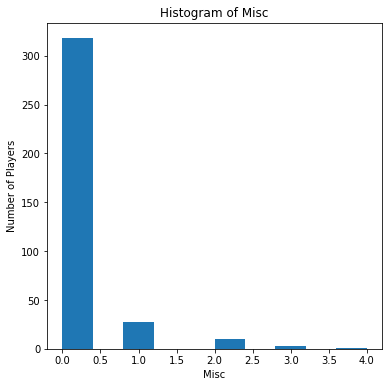

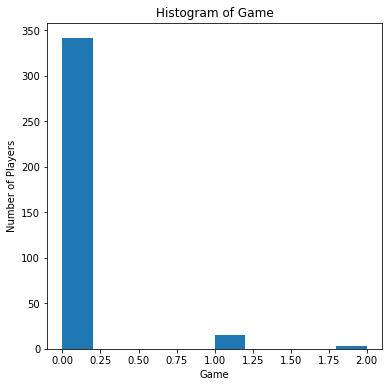

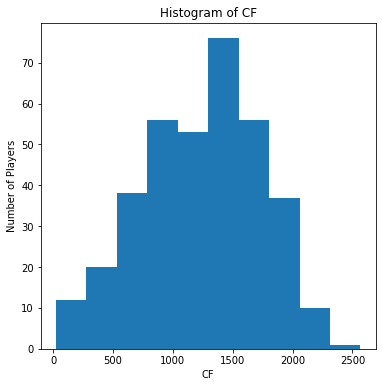

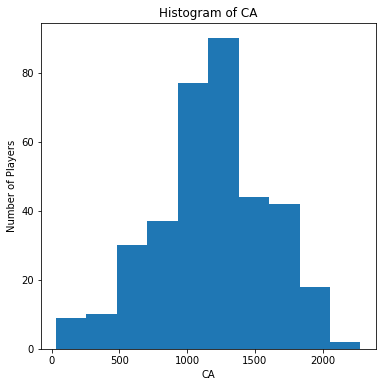

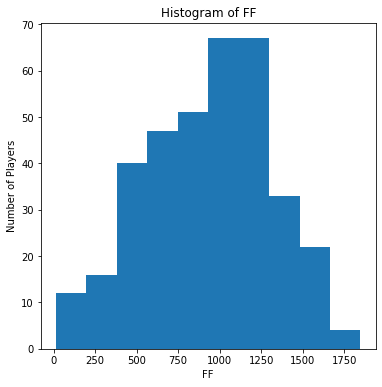

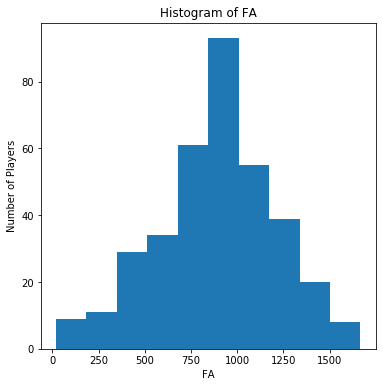

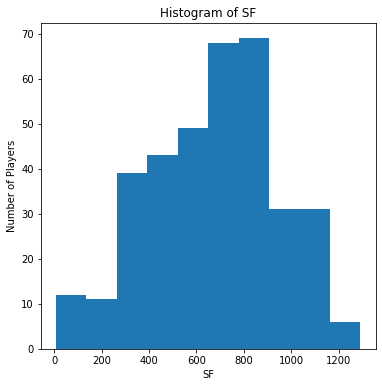

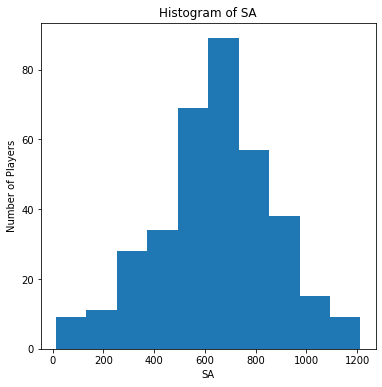

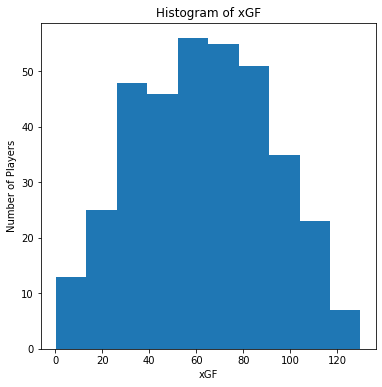

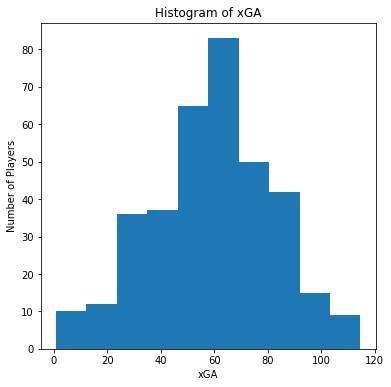

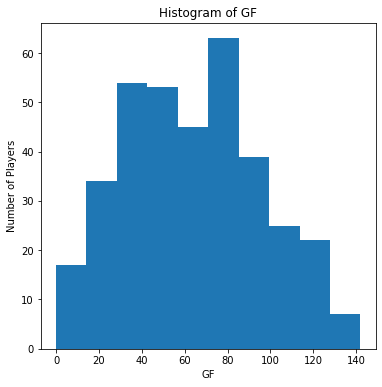

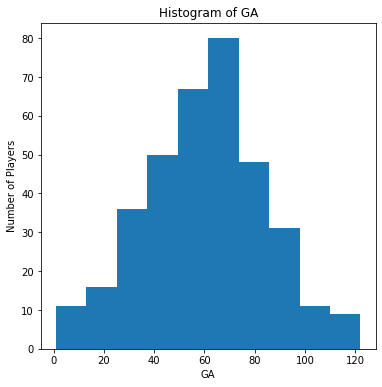

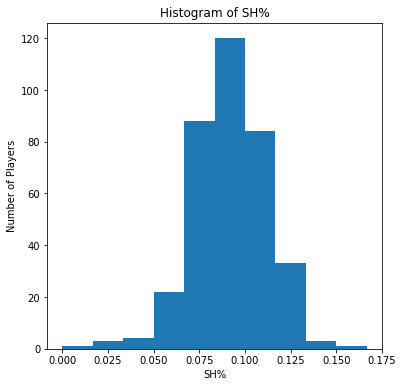

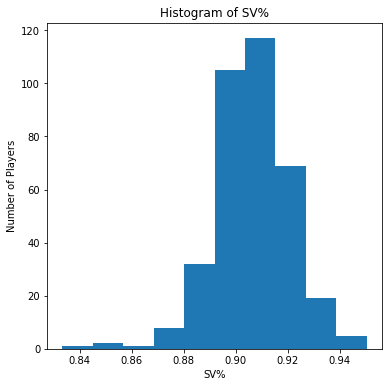

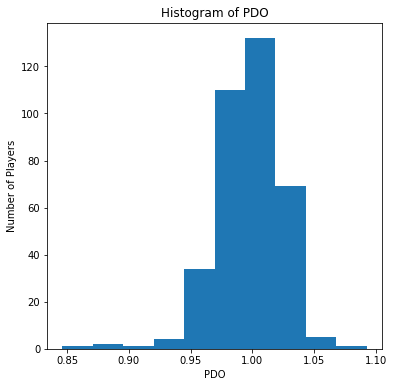

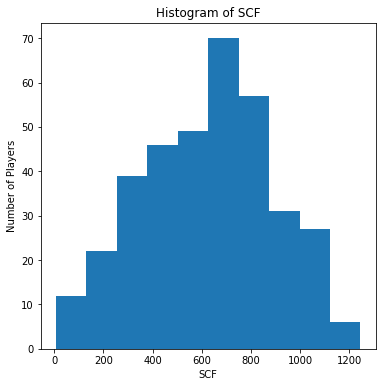

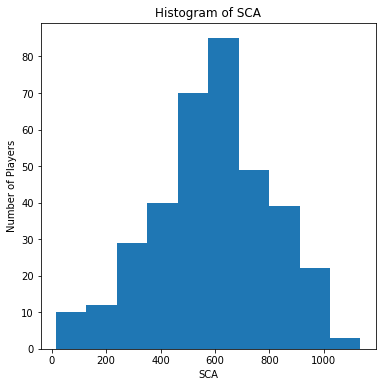

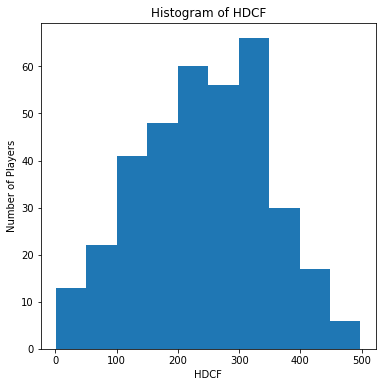

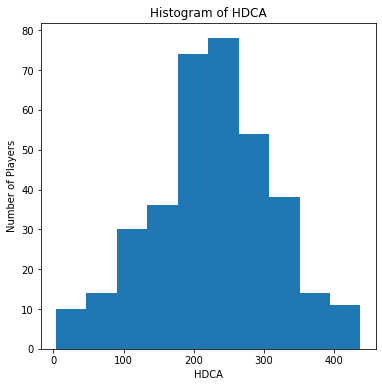

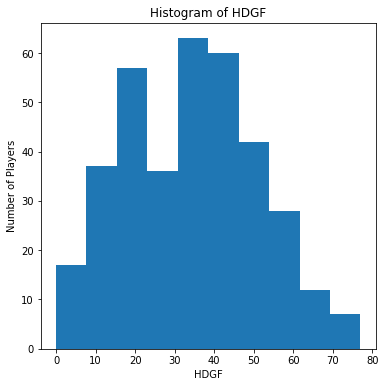

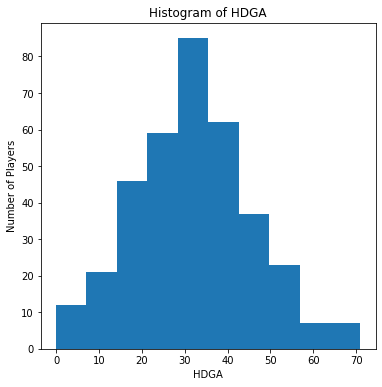

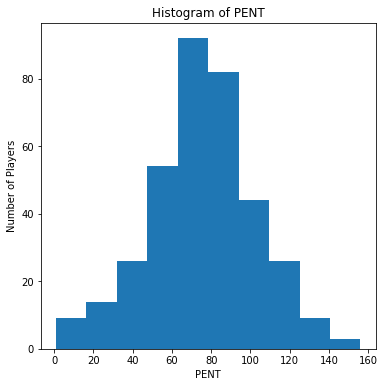

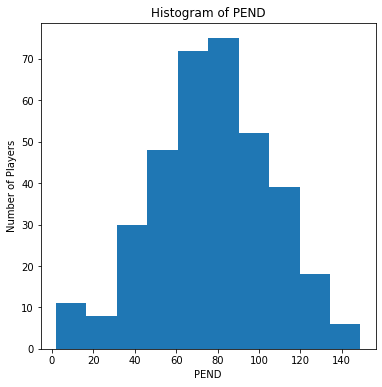

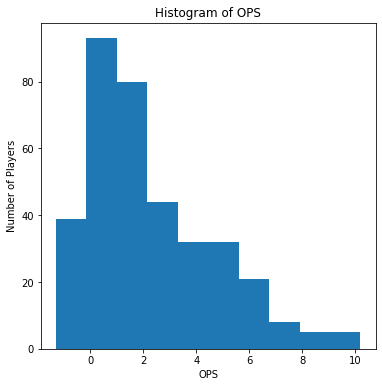

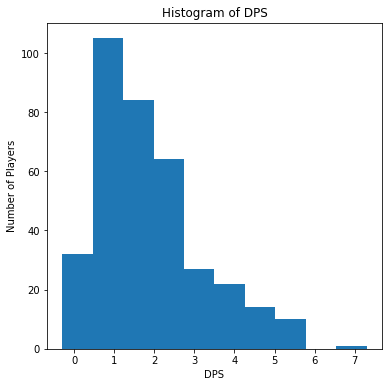

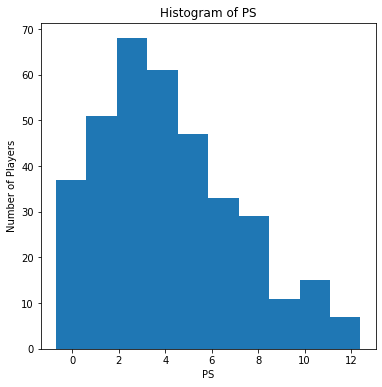

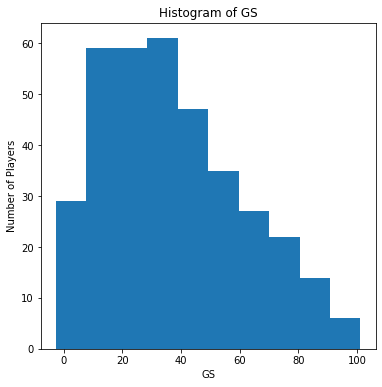

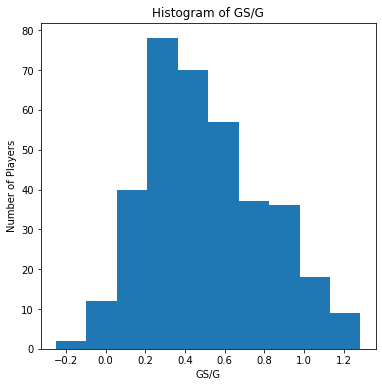

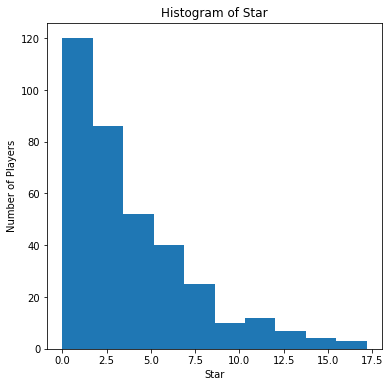

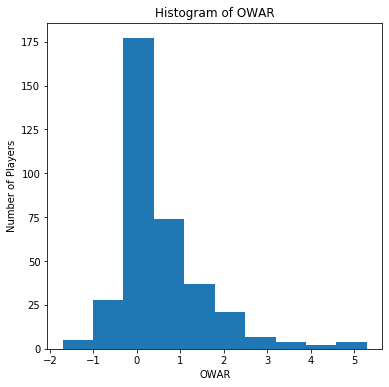

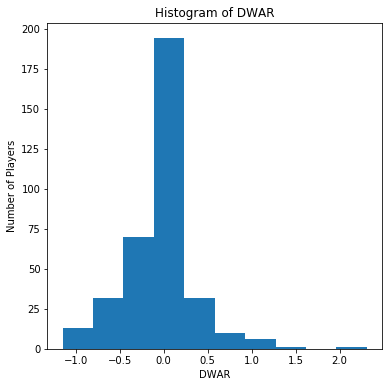

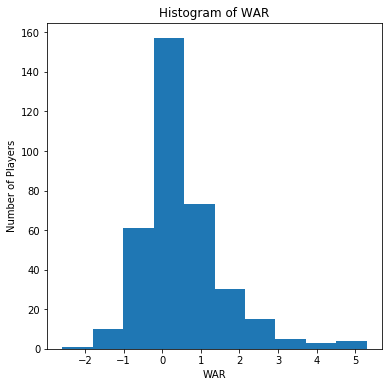

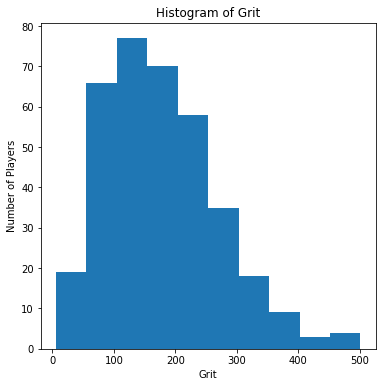

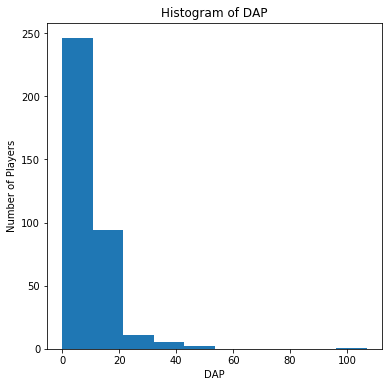

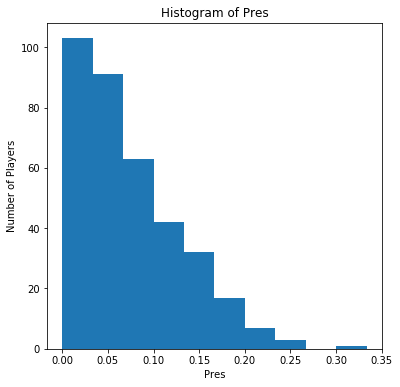

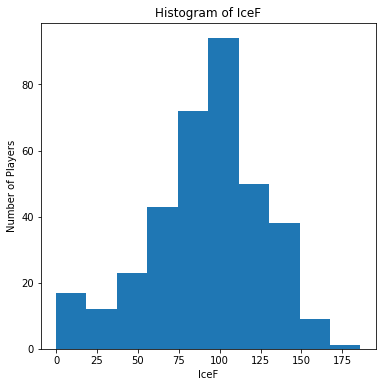

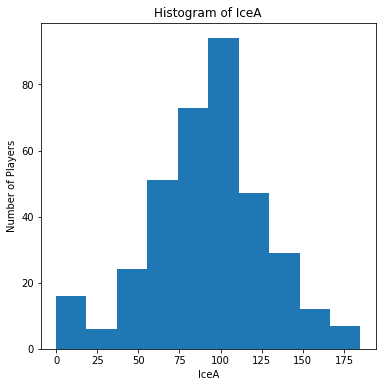

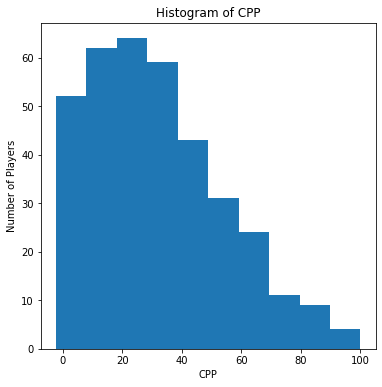

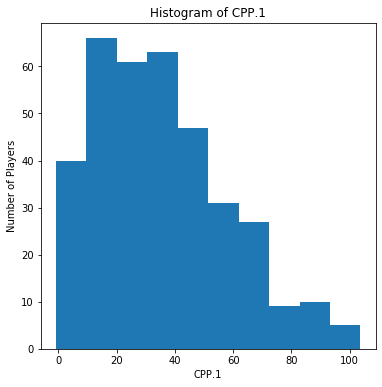

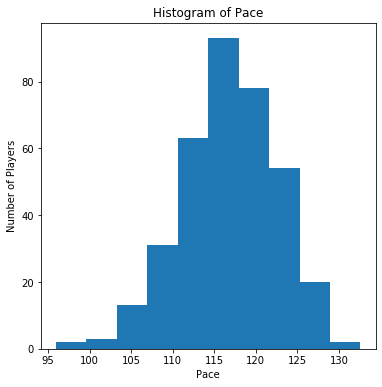

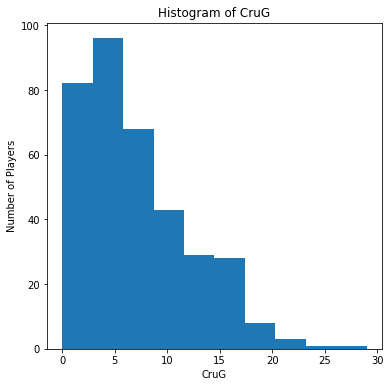

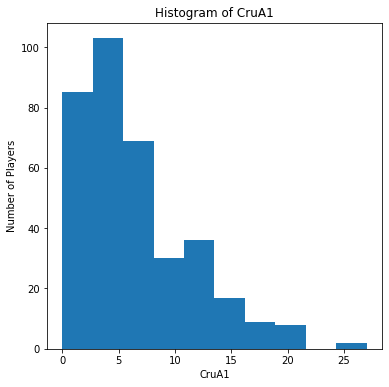

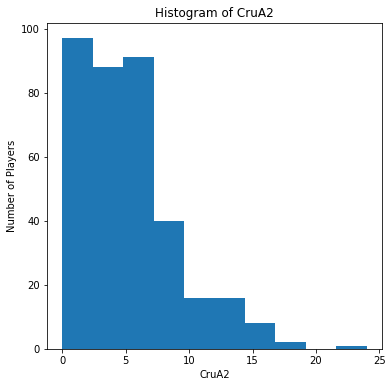

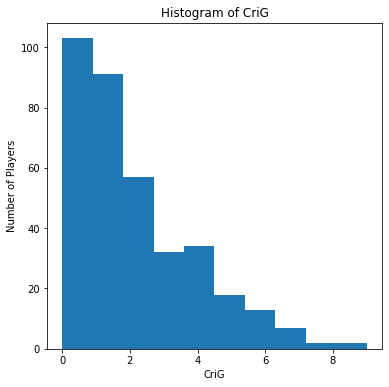

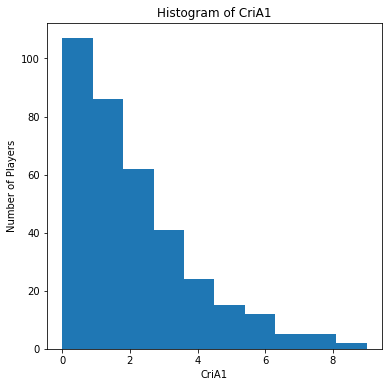

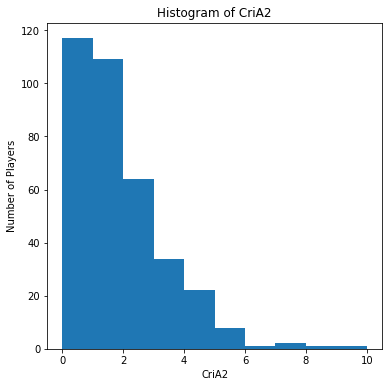

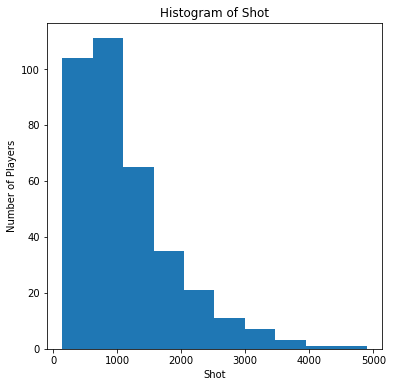

In [15]:
def plot_histogram(season18, cols, bins = 10):
    for col in cols:
        fig = plt.figure(figsize=(6,6)) # define plot area
        ax = fig.gca() # define axis    
        season18[col].plot.hist(ax = ax, bins = bins) # Use the plot.hist method on subset of the data frame
        ax.set_title('Histogram of ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel('Number of Players')# Set text for y axis
        plt.show()
        
num_cols = list(modelSeason18X.columns)
plot_histogram(modelSeason18X, num_cols)

In [16]:
from sklearn import preprocessing

x = modelSeason18X.values
normalized = preprocessing.normalize(x)
modelSeason18X = pd.DataFrame(normalized)

In [17]:
modelSeason18['Cap Hit'].dtypes

dtype('float64')

In [18]:
y=np.log(modelSeason18['Cap Hit'].astype('float64'))

In [19]:
#Backward Elimination
cols = list(modelSeason18X.columns)
pmax = 1
#y=np.log(modelSeason18['Cap Hit'].astype('float64'))
count=0
while (len(cols)>0):
    if(count%100==0):
        print(count)
    count=count+1
    p= []
    X_1 = modelSeason18X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(list(y),X_1.astype(float)).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)  
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

0


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


100
[1, 4, 7, 8, 12, 15, 17, 19, 20, 21, 22, 23, 24, 31, 34, 38, 39, 41, 43, 44, 48, 54, 60, 91, 104, 107, 111, 112, 113, 117, 119, 125, 126, 131, 136, 138, 139]


In [20]:
season18.columns[selected_features_BE]

Index(['City', 'Nat', 'DftYr', 'DftRd', 'Age', 'CorsicaID', 'Last Name',
       'Position', 'Team', 'GP', 'G', 'A', 'PTS', 'E+/-', 'TOI', 'iCF', 'iFF',
       'iSCF', 'iRush', 'iReb', 'Pass', 'ZS%', 'iTKA', 'G.Wrst', 'iPenD',
       'iPenDf', 'Match', 'Misc', 'Game', 'FA', 'SA', 'SV%', 'PDO', 'HDGF',
       'DPS', 'GS', 'GS/G'],
      dtype='object')

In [21]:
y

0      15.363073
1      15.068274
2      14.914123
4      15.201805
5      15.520259
         ...    
390    15.193437
391    15.201805
392    15.520259
393    15.165437
394    15.687313
Name: Cap Hit, Length: 359, dtype: float64

In [22]:
len(selected_features_BE)

37

In [23]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [24]:
X_train, X_test, y_train, y_test = train_test_split(modelSeason18X,y, test_size = 0.2, random_state = 0)

In [25]:
X2_train=X_train[[5, 8, 14, 15, 20, 21, 22, 27, 38, 39, 40, 42, 43, 51, 57, 85, 89, 90, 91, 94, 96, 104, 105, 107, 110, 118, 133, 136, 143]]
y2_train=y_train.copy()
X2_test=X_test[[5, 8, 14, 15, 20, 21, 22, 27, 38, 39, 40, 42, 43, 51, 57, 85, 89, 90, 91, 94, 96, 104, 105, 107, 110, 118, 133, 136, 143]]
y2_test=y_test.copy()

In [26]:
reg = LassoCV()
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_test,y_test))
coef = pd.Series(reg.coef_, index = X_test.columns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006261725598459833, tolerance: 0.005549042833874691
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0067680069667126475, tolerance: 0.005549042833874691
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase th

Best alpha using built-in LassoCV: 0.000106
Best score using built-in LassoCV: 0.366232


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008421010202440016, tolerance: 0.005320181260004035
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00856994654074228, tolerance: 0.005320181260004035
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00836464523950653, tolerance: 0.005320181260004035
  tol, rng, random, positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not conver

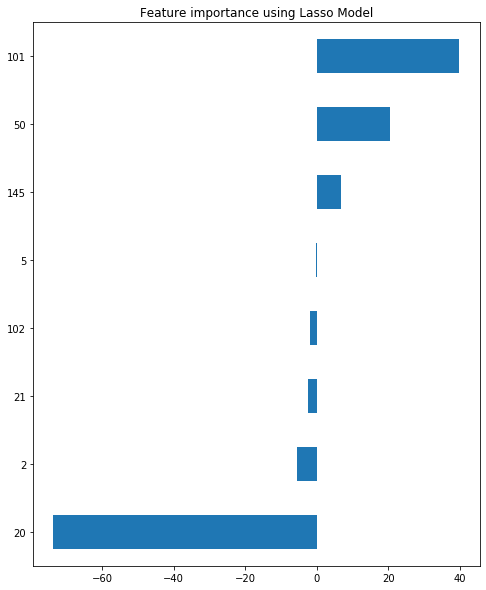

In [27]:
imp_coef = coef.sort_values()
imp_coef=imp_coef[imp_coef!=0]
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

In [28]:
len(y)

359

(array([22., 14., 27., 24., 33., 59., 65., 70., 34., 11.]),
 array([13.86430072, 14.09455923, 14.32481774, 14.55507625, 14.78533476,
        15.01559327, 15.24585178, 15.47611029, 15.7063688 , 15.93662731,
        16.16688582]),
 <a list of 10 Patch objects>)

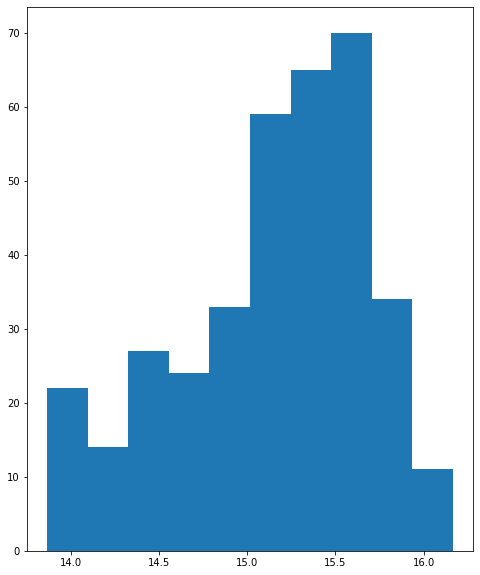

In [29]:
plt.hist(y)

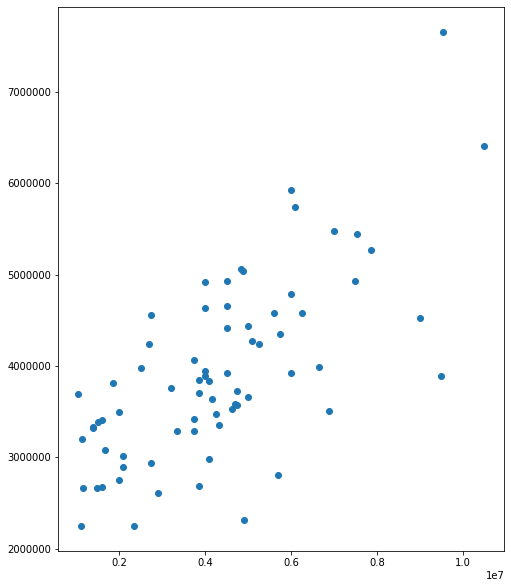

In [30]:
plt.scatter(np.exp(y_test),np.exp(reg.predict(X_test)))

(array([ 1.,  2.,  1.,  5.,  5., 14., 18., 10., 10.,  6.]),
 array([-77905.39653542, -66444.36756757, -54983.33859971, -43522.30963186,
        -32061.28066401, -20600.25169616,  -9139.22272831,   2321.80623954,
         13782.83520739,  25243.86417524,  36704.89314309]),
 <a list of 10 Patch objects>)

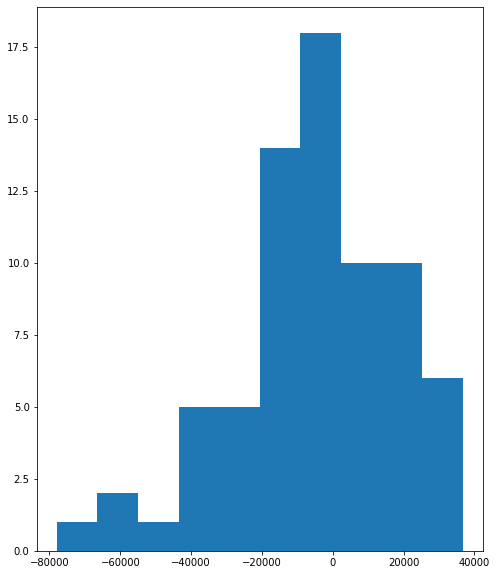

In [31]:
plt.hist((np.exp(reg.predict(X_test))-np.exp(y_test))/len(y_test))

(array([22., 16., 14., 10.,  5.,  1.,  1.,  2.,  0.,  1.]),
 array([5.80737959e+01, 7.84280607e+03, 1.56275383e+04, 2.34122706e+04,
        3.11970029e+04, 3.89817352e+04, 4.67664674e+04, 5.45511997e+04,
        6.23359320e+04, 7.01206643e+04, 7.79053965e+04]),
 <a list of 10 Patch objects>)

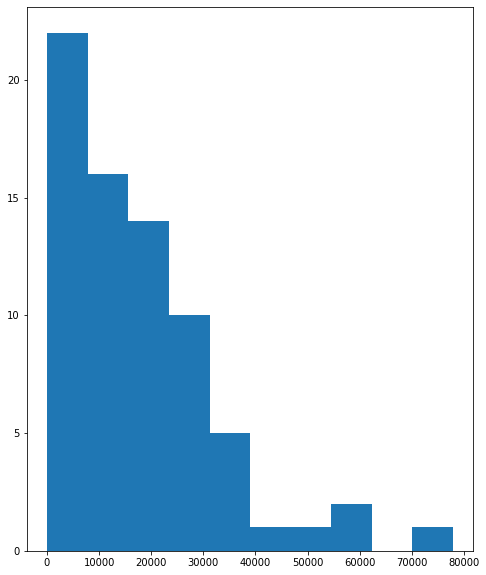

In [32]:
plt.hist((abs(np.exp(reg.predict(X_test))-np.exp(y_test)))/len(y_test))

In [33]:
diff=np.exp(reg.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-3371972.657447482
-146020.59846032457
1933242.4590058867
19


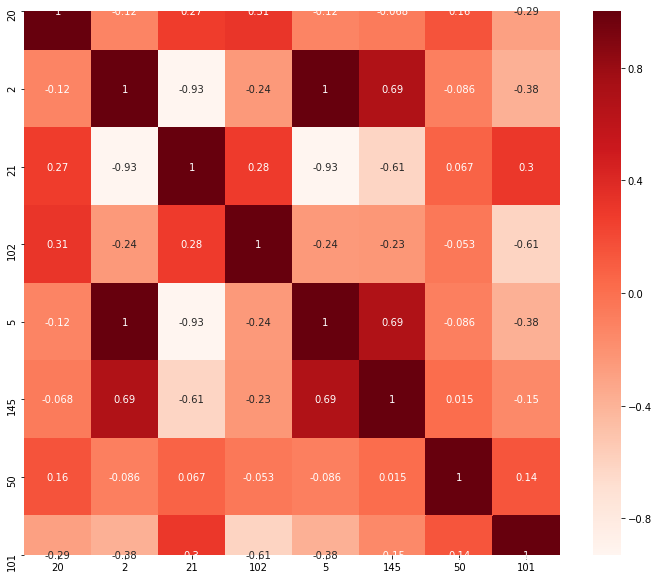

In [34]:
corr = modelSeason18X[imp_coef.index].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr.loc[corr.columns,corr.columns], annot=True, cmap=plt.cm.Reds)
plt.show()

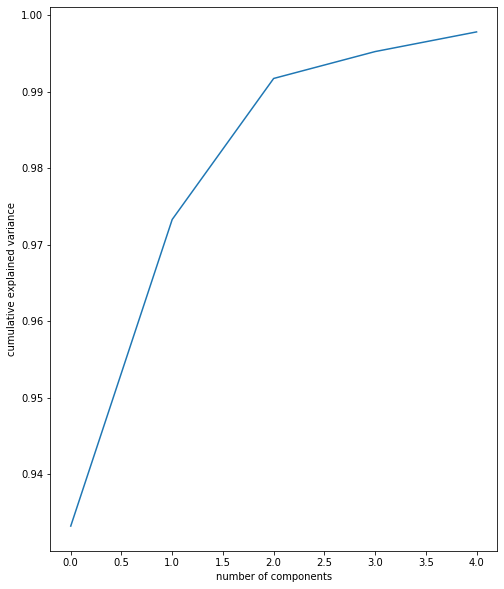

In [35]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[0:5])
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [36]:
pca=PCA(2)
pca.fit(X_train)
pcatrain_x = pca.transform(X_train)
pcatest_x = pca.transform(X_test)
reg = LassoCV()
reg.fit(pcatrain_x, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [37]:
diff=np.exp(reg.predict(pcatest_x))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))
print(reg.score(pcatest_x, y_test))

-5029428.225760007
-281488.86883907765
2454634.368592035
17
0.0976758727270669


In [38]:
import xgboost as xgb
dtrain=xgb.DMatrix(X_train,y_train)
dtest=xgb.DMatrix(X_test,y_test)
params={
    'objective':"reg:squarederror",
    'eval_metric':["rmse","mae"]
}
evallist=[(dtest,'eval'),(dtrain,'train')]

In [39]:
num_round = 1000
bst=xgb.train(params,dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-rmse:10.26212	eval-mae:10.24631	train-rmse:10.28330	train-mae:10.26957
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-rmse:7.19870	eval-mae:7.17614	train-rmse:7.21897	train-mae:7.19940
[2]	eval-rmse:5.05599	eval-mae:5.02382	train-rmse:5.07496	train-mae:5.04708
[3]	eval-rmse:3.54984	eval-mae:3.50892	train-rmse:3.57686	train-mae:3.54307
[4]	eval-rmse:2.50610	eval-mae:2.45457	train-rmse:2.52976	train-mae:2.48747
[5]	eval-rmse:1.78387	eval-mae:1.72005	train-rmse:1.79897	train-mae:1.75175
[6]	eval-rmse:1.28532	eval-mae:1.20639	train-rmse:1.28621	train-mae:1.23666
[7]	eval-rmse:0.94741	eval-mae:0.86170	train-rmse:0.92448	train-mae:0.87643
[8]	eval-rmse:0.72700	eval-mae:0.64583	train-rmse:0.66962	train-mae:0.62481
[9]	eval-rmse:0.58193	eval-mae:0.50127	train-rmse:0.49108	train-mae:0.44366
[10]	eval-rmse:0.50533	eval-mae:0.41704	train-rmse:0.36262	train-mae:0.31748
[11]	eval-rmse:0

In [40]:
xgbPred=bst.predict(dtest,ntree_limit=bst.best_ntree_limit)

In [41]:
diff=np.exp(xgbPred)-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))


-3395519.4999999963
2525.9999999976717
2080682.9999999993
18


In [42]:
from sklearn.metrics import mean_squared_error
mean_squared_error(xgbPred,y_test)

0.15400128109847924

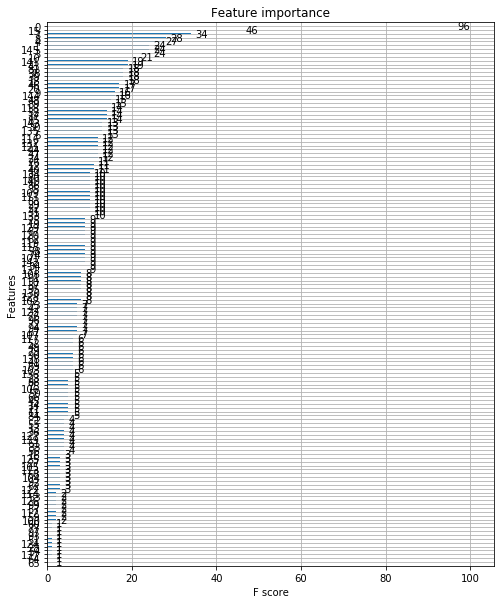

In [43]:
xgb.plot_importance(bst)

(array([ 1.,  1.,  3.,  6.,  3., 12., 15., 18.,  7.,  6.]),
 array([-4.963336 , -4.2189487, -3.4745614, -2.7301741, -1.9857868,
        -1.2413995, -0.4970122,  0.2473751,  0.9917624,  1.7361497,
         2.480537 ]),
 <a list of 10 Patch objects>)

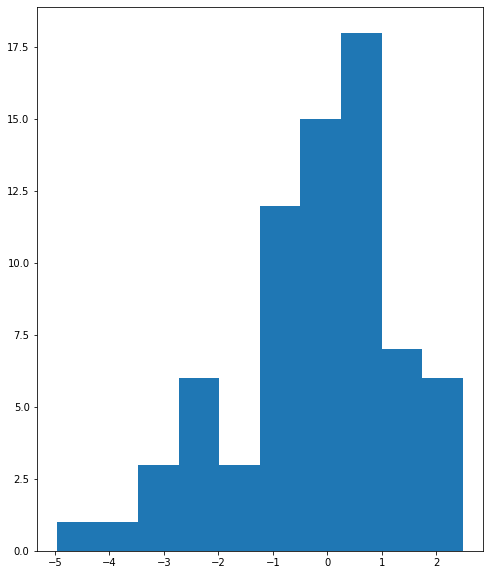

In [44]:
plt.hist((diff)/1000000)

In [45]:
len(diff[abs(diff)<500000])

18

In [46]:
from sklearn.tree import DecisionTreeRegressor

dtree=DecisionTreeRegressor()
#dtree.fit(X2_train,y2_train)
dtree.fit(X_train,y_train)

#diff=dtree.predict(X2_test)-y2_test
diff=np.exp(dtree.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)

(array([ 1.,  1.,  2.,  5.,  9., 17., 17.,  7.,  9.,  4.]),
 array([-6449999.99999998, -5354999.99999999, -4259999.99999999,
        -3164999.99999999, -2069999.99999999,  -974999.99999999,
          120000.00000001,  1215000.00000001,  2310000.00000001,
         3405000.        ,  4500000.        ]),
 <a list of 10 Patch objects>)

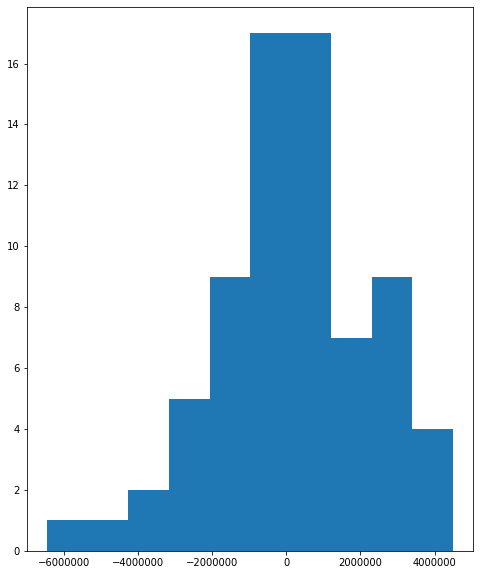

In [47]:
plt.hist(diff)

In [48]:
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-3624999.9999999925
200000.00000000163
3499999.999999998
22


In [49]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
svr.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [50]:
diff=np.exp(svr.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
sum(diff)/len(y_test)

-25059.77921376936

In [51]:
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-4737303.39239474
156741.04817639152
3107078.769940885
20


In [52]:
len(diff[abs(diff)<500000])/len(diff)

0.2777777777777778

In [53]:
from sklearn.linear_model import SGDRegressor

sgd=SGDRegressor(max_iter=1000, tol=1e-3)
sgd.fit(X_train,y_train)
sgd.score(X_test,y_test)

-0.009876583951326179

In [54]:
diff=np.exp(sgd.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-5113388.380909242
-200759.07183300145
2754313.1942119976
15


In [55]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor()
model.fit(X_train,y_train)

print(model.score(X_test,y_test))

0.5114757366640108


(array([ 1.,  3.,  1.,  4.,  6., 10., 17.,  8.,  9., 13.]),
 array([-6606625.37109136, -5661802.57260522, -4716979.77411907,
        -3772156.97563293, -2827334.17714678, -1882511.37866064,
         -937688.58017449,     7134.21831165,   951957.0167978 ,
         1896779.81528395,  2841602.61377009]),
 <a list of 10 Patch objects>)

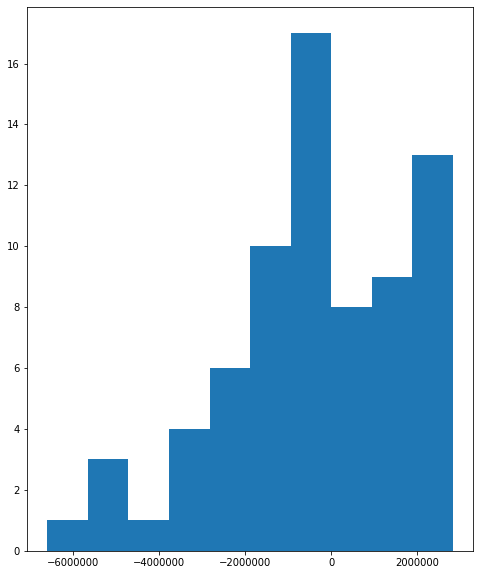

In [56]:
plt.hist(diff)

In [57]:
np.std(diff)

2161504.452366737

In [58]:
model = BaggingRegressor()
model.fit(X2_train,y2_train)

diff=np.exp(model.predict(X2_test))-np.exp(y2_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))
print(model.score(X2_test,y2_test))

-2857769.6774757234
-177430.7088495614
2247448.0796858827
21
0.3913351560926353


(array([ 2.,  1.,  3.,  6., 11., 11., 15., 12.,  4.,  7.]),
 array([-4563149.99134014, -3841710.27366952, -3120270.5559989 ,
        -2398830.83832828, -1677391.12065766,  -955951.40298704,
         -234511.68531641,   486928.03235421,  1208367.75002483,
         1929807.46769545,  2651247.18536607]),
 <a list of 10 Patch objects>)

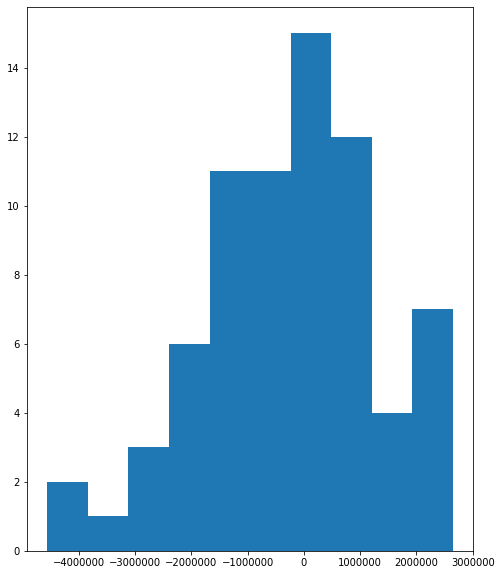

In [59]:
plt.hist(diff)

In [60]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=1000000).fit(X_train, y_train)
regr.predict(X_test)
regr.score(X_test, y_test)

0.0335091060445738

In [61]:
diff=np.exp(regr.predict(X_test))-np.exp(y_test)
diff=diff.sort_values()
diff=diff.reset_index(drop=True)
print(diff[int(len(diff)*.05)])
print(diff[int(len(diff)*.5)])
print(diff[int(len(diff)*.95)])
print(len(diff[abs(diff)<500000]))

-4745797.59176764
-751623.5724634947
2135169.6220169594
9
